In [ ]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets
!pip install evaluate
!pip install scikit-learn
!pip install transformers
!pip install wandb
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 28.0 MB/s eta 0:00:00


In [ ]:


import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset, DatasetDict
from evaluate import load as load_metric
import wandb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader
import emoji
import re  # For regular expressions


In [ ]:
# Set file paths
train_path = '/content/drive/MyDrive/data/datasets/train.csv'
test_path = '/content/drive/MyDrive/data/datasets/test.csv'

# Load the data
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [ ]:
# Replace 'NONE' with 0 in emotion columns
label_names = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
df_train[label_names] = df_train[label_names].replace('NONE', 0).astype(int)
df_test[label_names] = df_test[label_names].replace('NONE', 0).astype(int)

<ipython-input-44-d4ce96155885>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test[label_names] = df_test[label_names].replace('NONE', 0).astype(int)


In [ ]:
# Split data into train and validation sets
train_df, val_df = train_test_split(df_train, test_size=0.2, random_state=42)

# Convert DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(df_test)

In [ ]:
# Model and Tokenizer
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
max_length = 128

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Function to preprocess text
def preprocess_text(text):
  # Expand contractions
  text = re.sub(r"n\'t", " not", text)
  text = re.sub(r"\'re", " are", text)
  # ... other contractions ...

  # Remove unnecessary characters and extra whitespace
  text = re.sub(r"[^\w\s]", "", text)
  text = re.sub(r"\s+", " ", text).strip()

  # Handle URLs and hashtags (you can customize this)
  text = re.sub(r"http\S+", "URL", text)
  text = re.sub(r"#\w+", "HASHTAG", text)

  # Handle emojis
  text = emoji.demojize(text)  # Convert emojis to text descriptions
  text = re.sub(r":[^:]+:", "", text)  # Remove emoji descriptions

  return text

# Tokenization function
def preprocess_function(examples):
    examples["Tweet"] = [preprocess_text(text) for text in examples["Tweet"]]
    return tokenizer(examples["Tweet"], padding="max_length", truncation=True, max_length=max_length)


In [ ]:
# Tokenize datasets
train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/6179 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [ ]:

# Prepare labels for multi-label classification
def prepare_labels(batch):
    labels = torch.tensor([batch[label] for label in label_names], dtype=torch.float).T
    batch["labels"] = labels
    return batch

train_dataset = train_dataset.map(prepare_labels, remove_columns=label_names)
val_dataset = val_dataset.map(prepare_labels, remove_columns=label_names)
test_dataset = test_dataset.map(prepare_labels, remove_columns=label_names)

Map:   0%|          | 0/6179 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [ ]:
# DataCollator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# Define the model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_names),
    problem_type="multi_label_classification"
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Calculate class weights (modified for multi-label)
class_weights = []
for label in label_names:
    # Calculate class weights using sklearn's compute_class_weight
    y = df_train[label].values  # Get labels for this emotion
    classes = np.unique(y)  # Get all unique labels in y
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
    class_weights.append(weights[1] if 1 in classes else 1.0)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# Define custom Trainer with weighted loss
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.logits

        # Apply BCEWithLogitsLoss with pos_weight for each label
        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [ ]:
# Training arguments with wandb logging
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",
    save_steps=100,
    eval_steps=100,
    logging_steps=100,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="wandb",
    run_name="roberta_emotion_detection",
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Define evaluation metrics
metric = load_metric("f1")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = (logits > 0).astype(int)
    macro_f1 = f1_score(labels, predictions, average='macro')
    micro_f1 = f1_score(labels, predictions, average='micro')
    accuracy = accuracy_score(labels.flatten(), predictions.flatten())
    return {'f1_micro': micro_f1, 'f1_macro': macro_f1, 'accuracy': accuracy}


In [ ]:
# Initialize Trainer
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)



In [ ]:
# Train the model
trainer.train()

Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
100,0.857200,0.750658,0.537738,0.443991,0.757105
200,0.719100,0.699147,0.568416,0.466810,0.800118
300,0.665900,0.641487,0.612756,0.518370,0.819947
400,0.634200,0.625248,0.621298,0.537391,0.810415
500,0.628200,0.628402,0.622116,0.537396,0.823654
600,0.632200,0.597512,0.645799,0.560046,0.835540
700,0.597700,0.586260,0.645487,0.572552,0.826655
800,0.564700,0.571895,0.644927,0.574379,0.821889
900,0.523400,0.585991,0.655028,0.585688,0.830244
1000,0.533100,0.589891,0.659773,0.577047,0.839306


TrainOutput(global_step=2319, training_loss=0.5540697793602789, metrics={'train_runtime': 492.3071, 'train_samples_per_second': 37.653, 'train_steps_per_second': 4.71, 'total_flos': 1219420938537216.0, 'train_loss': 0.5540697793602789, 'epoch': 3.0})

In [ ]:
# Evaluate the model on the validation set
eval_results = trainer.evaluate()
print("Validation Results:", eval_results)

Validation Results: {'eval_loss': 0.5554258227348328, 'eval_f1_micro': 0.6698612862547288, 'eval_f1_macro': 0.5937587153315156, 'eval_accuracy': 0.8459546925566344, 'eval_runtime': 5.3468, 'eval_samples_per_second': 288.959, 'eval_steps_per_second': 36.284, 'epoch': 3.0}


In [ ]:
# Evaluate the model on the test set
#test_results = trainer.evaluate(eval_dataset=test_dataset)
#print("Test Results:", test_results)

Test Results: {'eval_loss': 0.6840028762817383, 'eval_f1_micro': 0.0, 'eval_f1_macro': 0.0, 'eval_accuracy': 0.747329074730118, 'eval_runtime': 11.7618, 'eval_samples_per_second': 277.083, 'eval_steps_per_second': 34.688, 'epoch': 6.0}


In [ ]:
# Visualize performance with multilabel confusion matrix
def multilabel_evaluation(y_true, y_pred, class_names=None, figsize=(12, 8)):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_true.shape[1])]

    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # Individual Confusion Matrix Heatmaps
    n_classes = len(class_names)
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows / 2))
    for idx, matrix in enumerate(mcm):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                    xticklabels=['Pred Neg', 'Pred Pos'],
                    yticklabels=['True Neg', 'True Pos'])
        plt.title(f'{class_names[idx]}')
    plt.tight_layout()
    plt.show()

    # Metrics Heatmap
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }
    metrics_df = pd.DataFrame(metrics, index=class_names)

    plt.figure(figsize=(figsize[0] / 1.5, figsize[1] / 1.5))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Blues')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.show()

    # Metrics Histogram
    plt.figure(figsize=(figsize[0], figsize[1] / 1.5))
    metrics_df.plot(kind='bar', width=0.8)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Calculate and return summary statistics
    summary_stats = {
        'macro_avg': {
            'precision': np.mean(metrics['Precision']),
            'recall': np.mean(metrics['Recall']),
            'f1': np.mean(metrics['F1-Score'])
        },
        'per_class': metrics_df.to_dict()
    }
    return summary_stats

In [ ]:
# Predict on the test set for visualization
val_output = trainer.predict(val_dataset)
val_dataset_preds = (val_output.predictions > 0).astype(int)
val_labels = val_output.label_ids.astype(int)

In [ ]:
# Predict on the test set for visualization
test_output = trainer.predict(test_dataset)
test_preds = (test_output.predictions > 0).astype(int)
test_labels = test_output.label_ids.astype(int)

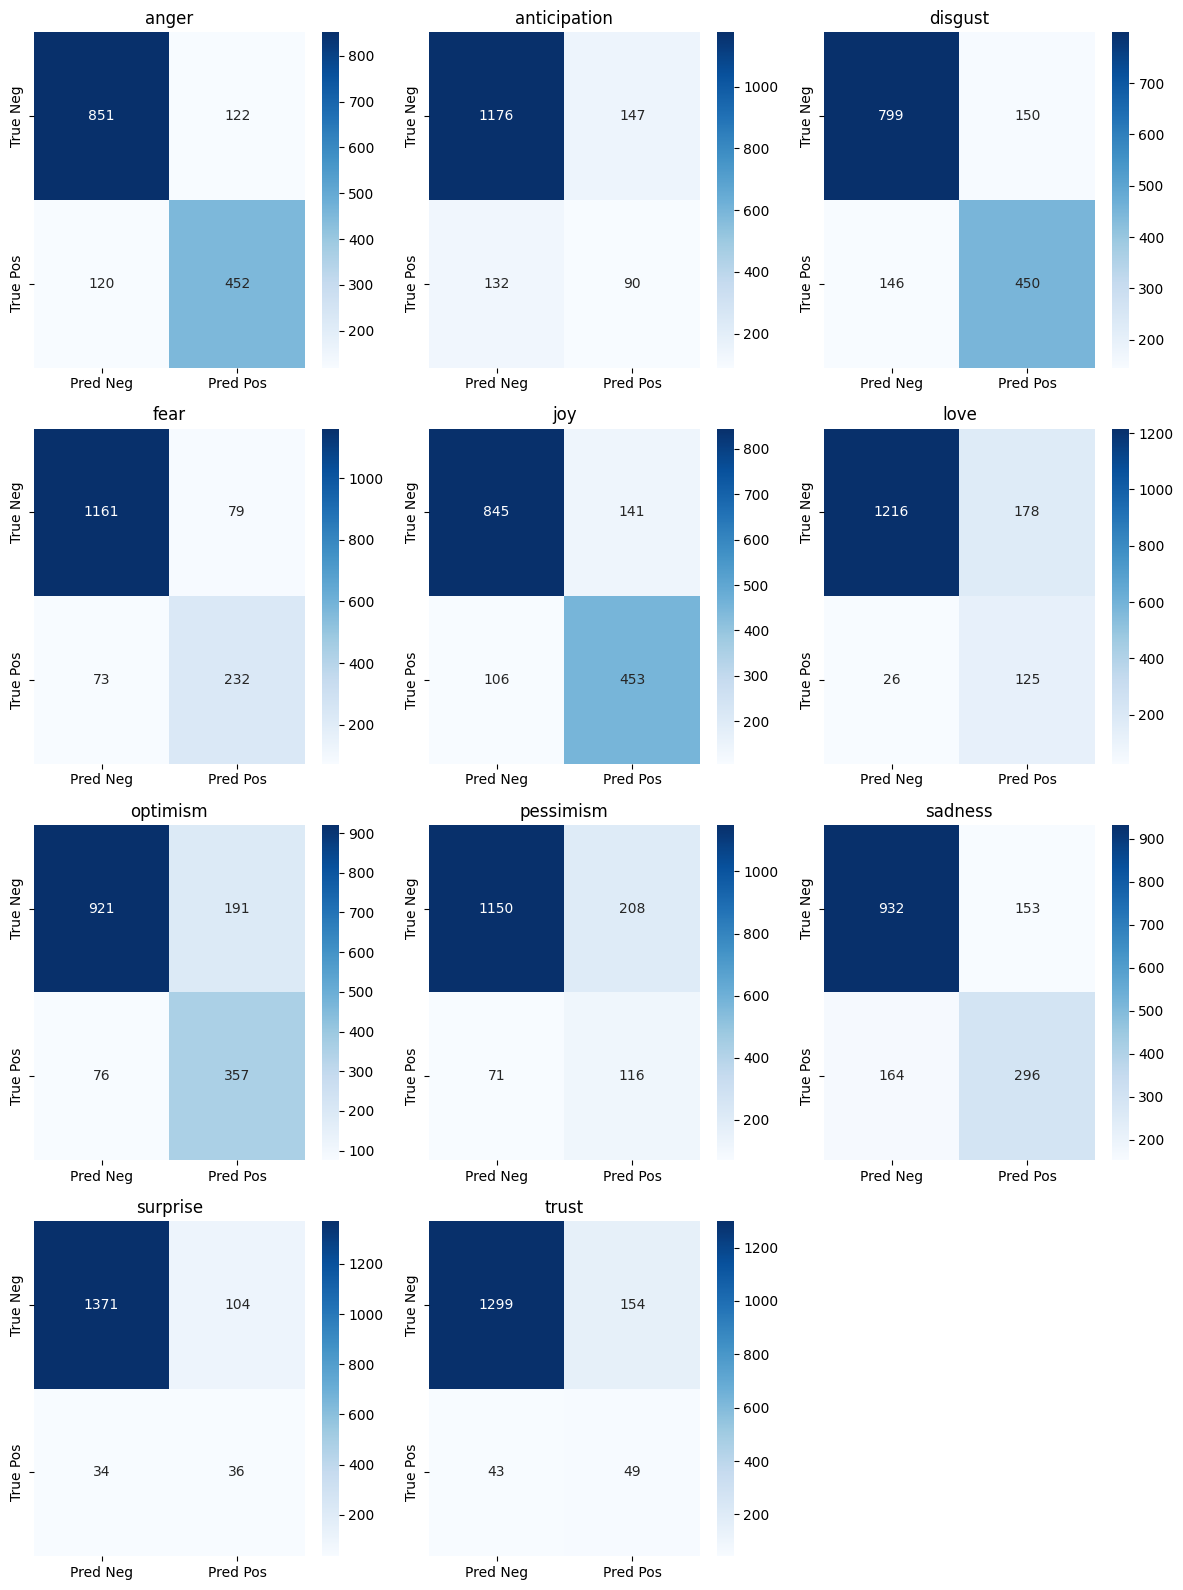

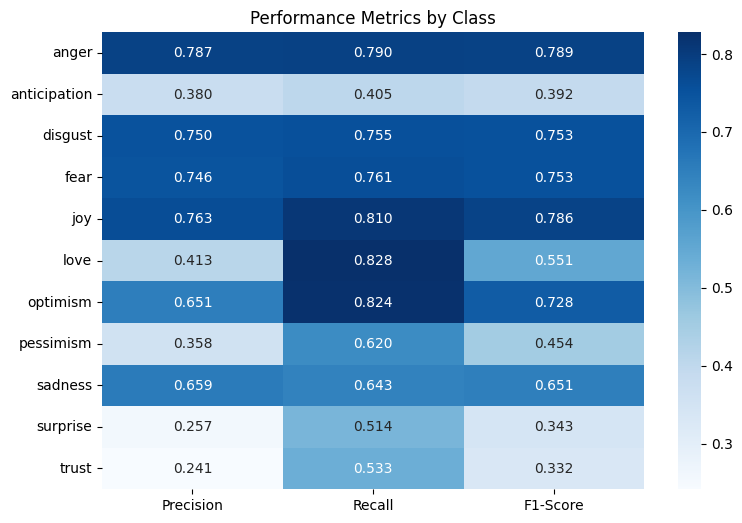

<Figure size 1200x533.333 with 0 Axes>

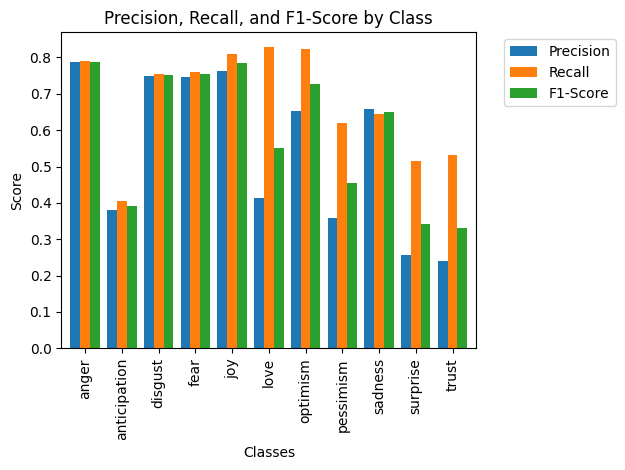

{'macro_avg': {'precision': 0.5459637254669274,
  'recall': 0.6804244206074311,
  'f1': 0.5937587153315156},
 'per_class': {'Precision': {'anger': 0.7874564459930313,
   'anticipation': 0.379746835443038,
   'disgust': 0.75,
   'fear': 0.7459807073954984,
   'joy': 0.7626262626262627,
   'love': 0.41254125412541254,
   'optimism': 0.6514598540145985,
   'pessimism': 0.35802469135802467,
   'sadness': 0.6592427616926503,
   'surprise': 0.2571428571428571,
   'trust': 0.2413793103448276},
  'Recall': {'anger': 0.7902097902097902,
   'anticipation': 0.40540540540540543,
   'disgust': 0.7550335570469798,
   'fear': 0.760655737704918,
   'joy': 0.8103756708407871,
   'love': 0.8278145695364238,
   'optimism': 0.8244803695150116,
   'pessimism': 0.6203208556149733,
   'sadness': 0.6434782608695652,
   'surprise': 0.5142857142857142,
   'trust': 0.532608695652174},
  'F1-Score': {'anger': 0.7888307155322862,
   'anticipation': 0.39215686274509803,
   'disgust': 0.7525083612040134,
   'fear': 

In [ ]:
# Plot evaluation metrics for test set
multilabel_evaluation(y_true=val_labels, y_pred=val_dataset_preds, class_names=label_names)

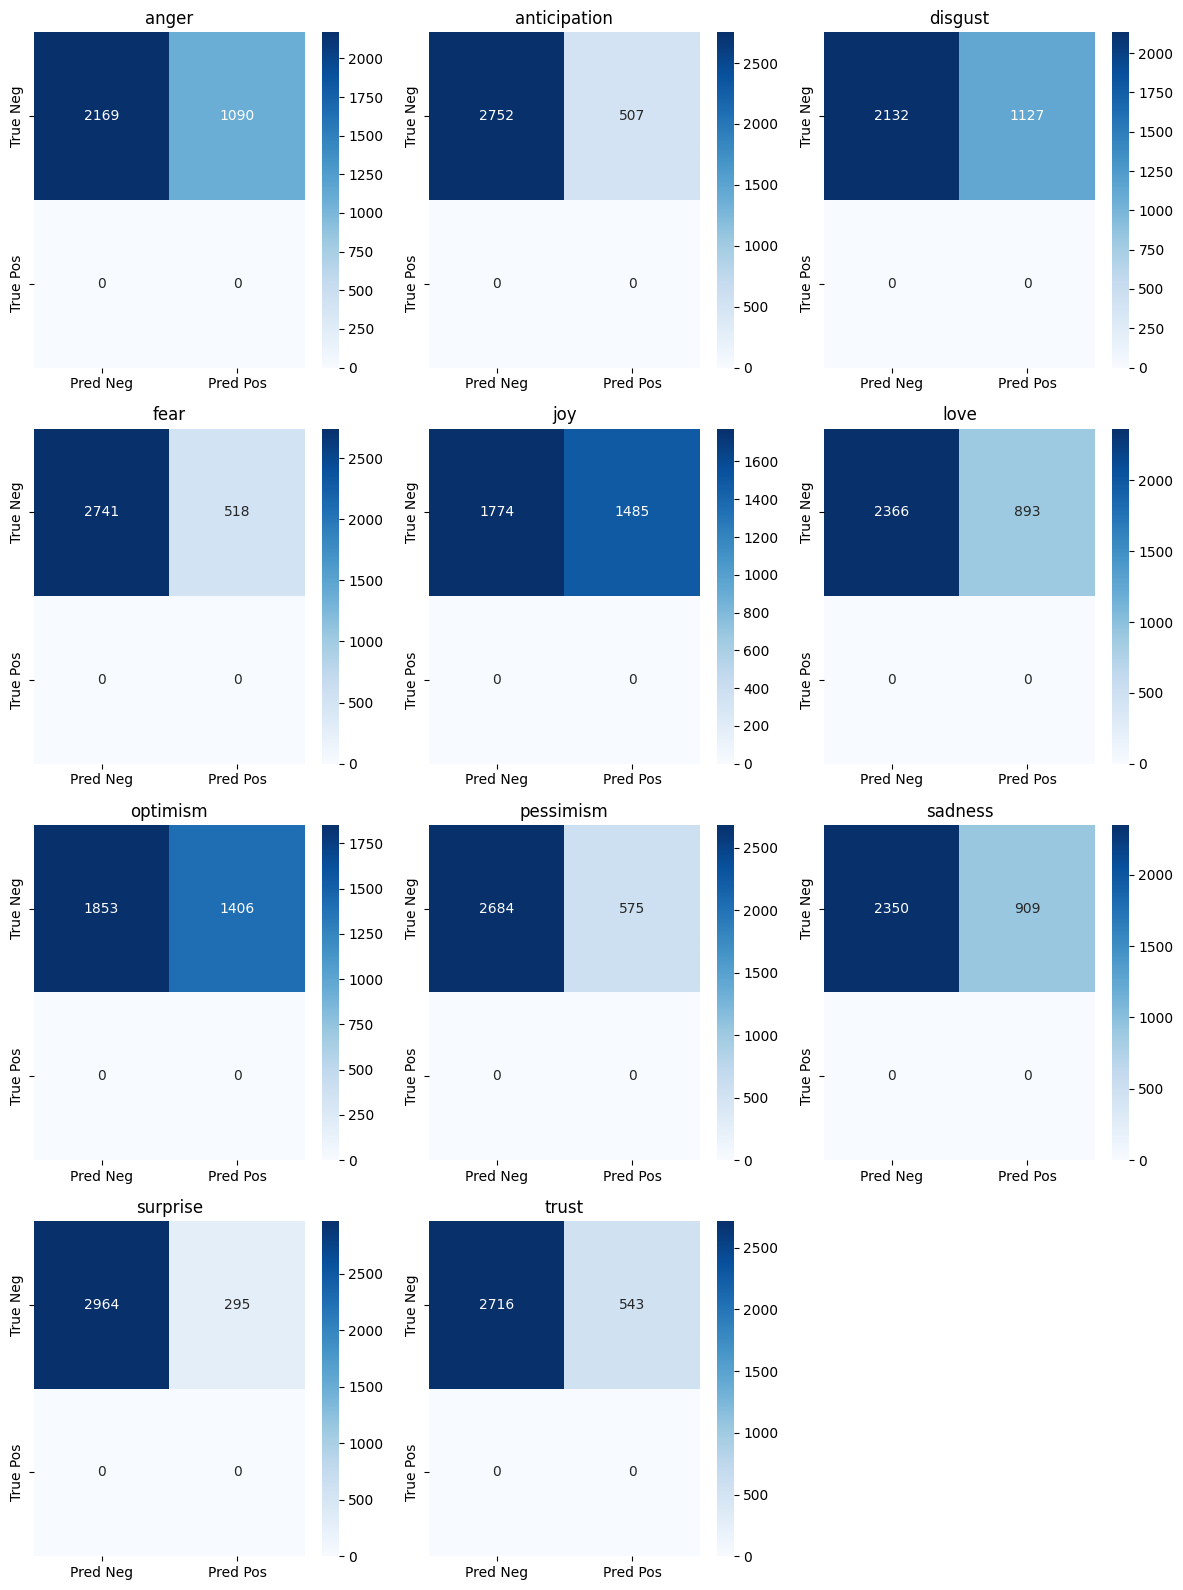

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


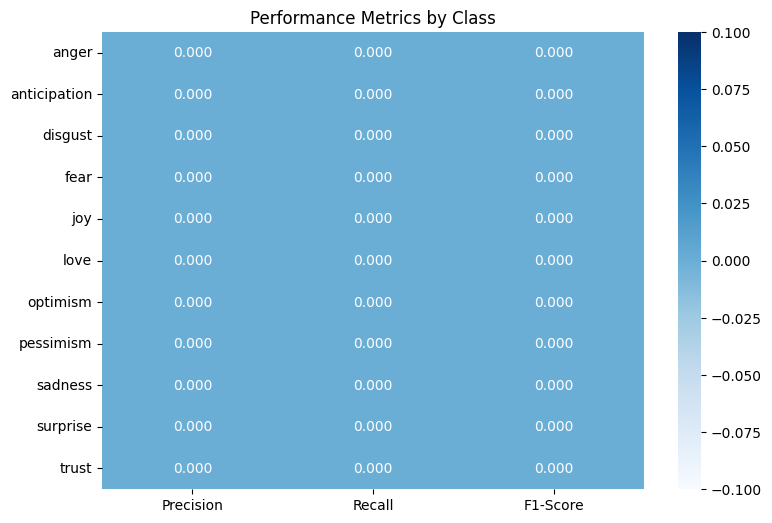

<Figure size 1200x533.333 with 0 Axes>

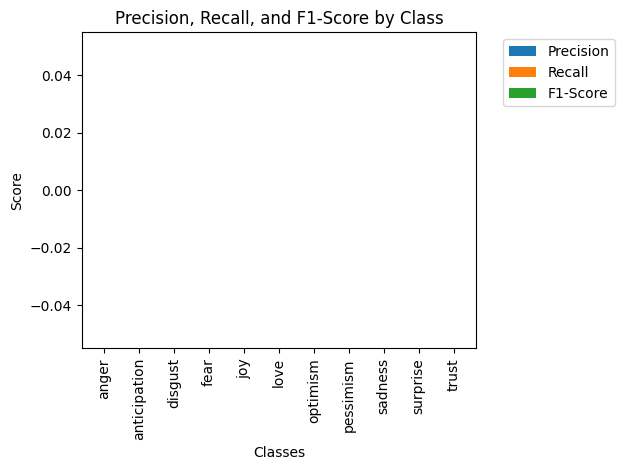

{'macro_avg': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0},
 'per_class': {'Precision': {'anger': 0.0,
   'anticipation': 0.0,
   'disgust': 0.0,
   'fear': 0.0,
   'joy': 0.0,
   'love': 0.0,
   'optimism': 0.0,
   'pessimism': 0.0,
   'sadness': 0.0,
   'surprise': 0.0,
   'trust': 0.0},
  'Recall': {'anger': 0.0,
   'anticipation': 0.0,
   'disgust': 0.0,
   'fear': 0.0,
   'joy': 0.0,
   'love': 0.0,
   'optimism': 0.0,
   'pessimism': 0.0,
   'sadness': 0.0,
   'surprise': 0.0,
   'trust': 0.0},
  'F1-Score': {'anger': 0.0,
   'anticipation': 0.0,
   'disgust': 0.0,
   'fear': 0.0,
   'joy': 0.0,
   'love': 0.0,
   'optimism': 0.0,
   'pessimism': 0.0,
   'sadness': 0.0,
   'surprise': 0.0,
   'trust': 0.0}}}

In [ ]:
# Plot evaluation metrics for test set
multilabel_evaluation(y_true=test_labels, y_pred=test_preds, class_names=label_names)

In [ ]:
# Best checkpoint identification for inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")

The best model was saved at step 3700.


In [ ]:
# Convert predictions and IDs to a DataFrame
test_ids = df_test["ID"].values  # Assuming you have df_test loaded with the test dataset including the ID column

# Convert predictions to a DataFrame
preds_df = pd.DataFrame(test_preds, columns=label_names)
preds_df.insert(0, "ID", test_ids)  # Insert IDs as the first column

In [ ]:
# Save the DataFrame as a CSV file
preds_df.to_csv("test_predictions.csv", index=False)
print("File saved as test_predictions.csv")

File saved as test_predictions.csv
